In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install librosa
#!pip install tensorflow
import librosa
import librosa.display
import soundfile as sf
import random
import configparser
import math
#import tensorflow as tf 
#import utility_functions as uf
import IPython.display as ipd
from IPython.display import Audio

#!pip install audiomentations
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
from sklearn.preprocessing import LabelEncoder

In [182]:
data = pd.read_csv('fully_balanced_audio_dataset.csv')


,Speech,Emotion,audio_path,emotion
0,C:\Users\admin\OneDrive - Sol Plaatje Universi...,neutral,NaN,NaN
1,C:\Users\admin\OneDrive - Sol Plaatje Universi...,neutral,NaN,NaN
2,C:\Users\admin\OneDrive - Sol Plaatje Universi...,neutral,NaN,NaN
3,C:\Users\admin\OneDrive - Sol Plaatje Universi...,neutral,NaN,NaN
4,C:\Users\admin\OneDrive - Sol Plaatje Universi...,calm,NaN,NaN


In [184]:
# Assuming your DataFrame is named 'data'
data = data.drop(['audio_path', 'emotion'], axis=1)


In [185]:
data.tail(10)

,Speech,Emotion
1622,augmented_neutral_86.wav,neutral
1623,augmented_neutral_87.wav,neutral
1624,augmented_neutral_88.wav,neutral
1625,augmented_neutral_89.wav,neutral
1626,augmented_neutral_90.wav,neutral
1627,augmented_neutral_91.wav,neutral
1628,augmented_neutral_92.wav,neutral
1629,augmented_neutral_93.wav,neutral
1630,augmented_neutral_94.wav,neutral
1631,augmented_neutral_95.wav,neutral


In [186]:
data.isnull().sum()

Speech     96
Emotion    96
dtype: int64

In [187]:
data.shape

(1632, 2)

In [188]:
data['Emotion'].unique()

array(['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust',
       'surprised', nan], dtype=object)

In [189]:
# Assuming your DataFrame is named 'data'
data = data.dropna()
data.isnull().sum()

Speech     0
Emotion    0
dtype: int64

In [191]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1536 entries, 0 to 1631
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Speech   1536 non-null   object
 1   Emotion  1536 non-null   object
dtypes: object(2)
memory usage: 36.0+ KB


# data agumentation
1. Time Stretching:
Changes the speed of the audio without altering the pitch.
2. Pitch Shifting:
Shifts the pitch of the audio up or down.
3. Adding Noise:
Adds random noise to the audio signal, simulating real-world noise.
4. Shifting in Time:
Slightly shifts the audio data in time.
5. Volume Scaling:
Randomly increases or decreases the volume of the audio.

In [193]:
# Get the path of the first audio file
audio_path = data['Speech'][100]  

# Load the audio file using librosa
signal, sampling_rate = librosa.load(audio_path, sr=None)  # sr=None keeps the original sampling rate

print(f"The sampling rate of the audio file is: {sampling_rate} Hz")


The sampling rate of the audio file is: 48000 Hz


In [194]:
# Augmentation functions
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

def scale_volume(data, scaling_factor=1.0):
    return data * scaling_factor

def time_scaling(data, scale_factor=1.0):
    # Use time-stretching to change duration
    return librosa.effects.time_stretch(data, rate=scale_factor)


In [195]:
# Augment the DataFrame
def augment_dataframe(df, sampling_rate, augment_factor=2, output_dir='augmented_audio'):
    os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist
    augmented_speech_paths = []
    augmented_emotions = []

    # Loop through the data multiple times for augmentation
    for _ in range(augment_factor):
        for index, row in df.iterrows():
            speech = row['Speech']
            emotion = row['Emotion']
            
            # Load the speech data from the path
            data, _ = librosa.load(speech, sr=sampling_rate)
            
            # Apply augmentations
            augmented_speech_signal = random.choice([
                noise(data),
                stretch(data, rate=random.uniform(0.8, 1.2)),
                shift(data),
                pitch(data, sampling_rate, pitch_factor=random.uniform(-5, 5)),
                scale_volume(data, scaling_factor=random.uniform(0.7, 1.3)),  # Volume scaling
                time_scaling(data, scale_factor=random.uniform(0.8, 1.2))  # Time scaling
            ])
            
            # Save the augmented audio signal to a file
            augmented_filename = f'augmented_{index}_{_}.wav'
            augmented_path = os.path.join(output_dir, augmented_filename)
            sf.write(augmented_path, augmented_speech_signal, sampling_rate)
            
            # Append the path of the augmented speech and corresponding emotion
            augmented_speech_paths.append(augmented_path)
            augmented_emotions.append(emotion)
    
    # Create a new DataFrame with augmented speech paths and emotions
    df_augmented = pd.DataFrame({'Speech': augmented_speech_paths, 'Emotion': augmented_emotions})
    return df_augmented

# Example usage
sampling_rate = 48000  # Adjust based on your data
augment_factor = 3  # Number of times you want to augment the dataset
df_augmented = augment_dataframe(data, sampling_rate, augment_factor)

# Combine the original DataFrame with the augmented DataFrame if needed
data_combined = pd.concat([data, df_augmented], ignore_index=True)

# Save the combined DataFrame as a CSV file
data_combined.to_csv('combined_speech_data.csv', index=False)


In [196]:
data_combined.shape

(6144, 2)

In [197]:
data_combined.isnull().sum()

Speech     0
Emotion    0
dtype: int64

In [198]:
data_combined.head()

,Speech,Emotion
0,C:\Users\admin\OneDrive - Sol Plaatje Universi...,neutral
1,C:\Users\admin\OneDrive - Sol Plaatje Universi...,neutral
2,C:\Users\admin\OneDrive - Sol Plaatje Universi...,neutral
3,C:\Users\admin\OneDrive - Sol Plaatje Universi...,neutral
4,C:\Users\admin\OneDrive - Sol Plaatje Universi...,calm


In [199]:
data_combined['Emotion'].value_counts()

Emotion
neutral      768
calm         768
happy        768
sad          768
angry        768
fearful      768
disgust      768
surprised    768
Name: count, dtype: int64

In [200]:
df_augmented.head()

,Speech,Emotion
0,augmented_audio\augmented_0_48000.wav,neutral
1,augmented_audio\augmented_1_48000.wav,neutral
2,augmented_audio\augmented_2_48000.wav,neutral
3,augmented_audio\augmented_3_48000.wav,neutral
4,augmented_audio\augmented_4_48000.wav,calm


# data preprocesing 
1. normalization :  using min_max scaling
2. regulirazation 

In [43]:
dt = pd.read_csv('combined_speech_data.csv')

In [45]:
dt.shape

(4608, 2)

In [127]:
dt.head()

,Speech,Emotion,Processed_Speech
0,C:\Users\admin\OneDrive - Sol Plaatje Universi...,neutral,"[-74.95366, -71.60486, -70.816925, -72.786804,..."
1,C:\Users\admin\OneDrive - Sol Plaatje Universi...,neutral,"[-73.3961, -71.85274, -68.59448, -70.9953, -75..."
2,C:\Users\admin\OneDrive - Sol Plaatje Universi...,neutral,"[-110.75264, -112.70853, -114.175446, -116.294..."
3,C:\Users\admin\OneDrive - Sol Plaatje Universi...,neutral,"[-8.695847, -9.635956, -11.046082, -6.6589966,..."
4,C:\Users\admin\OneDrive - Sol Plaatje Universi...,calm,"[97.460724, 100.72427, 99.8342, 97.460724, 98...."


In [41]:
def normalize(signal):
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

def regularize(signal):
    return (signal * 510) - 255  # Scale to [-255, 255]

def endpoint_detection(signal, threshold=0.01):
    # Find the indices where the signal is above the threshold
    non_silent_indices = np.where(np.abs(signal) > threshold)[0]
    if len(non_silent_indices) == 0:
        return signal  # Return original signal if no non-silent indices are found
    return signal[non_silent_indices[0]:non_silent_indices[-1] + 1]


In [201]:

def preprocess_signal(signal, sampling_rate):
    # Apply endpoint detection
    signal = endpoint_detection(signal)

    # Normalize the signal
    normalized_signal = normalize(signal)

    # Regularize the signal
    regularized_signal = regularize(normalized_signal)

    return regularized_signal

# Preprocess the speech data in the DataFrame
def preprocess_dataframe(df, sampling_rate):
    processed_speech = []

    for index, row in df.iterrows():
        speech_path = row['Speech']
        # Load the audio file
        data, sr = librosa.load(speech_path, sr=sampling_rate)
        
        # Preprocess the signal
        processed_signal = preprocess_signal(data, sr)
        
        processed_speech.append(processed_signal)

    df['Processed_Speech'] = processed_speech
    return df

# Save the processed data as a new CSV file
data_combined.to_csv('processed_speech_data.csv', index=False)


In [202]:

# Example usage
sampling_rate = 48000  # Adjust based on your data
dt = preprocess_dataframe(dt, sampling_rate)


In [203]:
dt.head()

,Speech,Emotion,Processed_Speech
0,C:\Users\admin\OneDrive - Sol Plaatje Universi...,neutral,"[-74.95366, -71.60486, -70.816925, -72.786804,..."
1,C:\Users\admin\OneDrive - Sol Plaatje Universi...,neutral,"[-73.3961, -71.85274, -68.59448, -70.9953, -75..."
2,C:\Users\admin\OneDrive - Sol Plaatje Universi...,neutral,"[-110.75264, -112.70853, -114.175446, -116.294..."
3,C:\Users\admin\OneDrive - Sol Plaatje Universi...,neutral,"[-8.695847, -9.635956, -11.046082, -6.6589966,..."
4,C:\Users\admin\OneDrive - Sol Plaatje Universi...,calm,"[97.460724, 100.72427, 99.8342, 97.460724, 98...."


In [204]:
import numpy as np
import pandas as pd
import librosa
from scipy.signal import savgol_filter

# Function to calculate short-time energy
def short_time_energy(signal, frame_size, hop_length):
    energy = np.array([
        np.sum(np.square(signal[i:i + frame_size]))
        for i in range(0, len(signal), hop_length)
    ])
    return energy

# Function to calculate short-time zero-crossing rate
def short_time_zero_crossing_rate(signal, frame_size, hop_length):
    zcr = np.array([
        np.sum(np.abs(np.sign(signal[i:i + frame_size][:-1]) - np.sign(signal[i:i + frame_size][1:])))
        for i in range(0, len(signal), hop_length)
    ])
    return zcr

# Function to calculate short-time average amplitude difference (AMDF)
def short_time_amdf(signal, frame_size, hop_length):
    amdf = np.array([
        np.mean(np.abs(signal[i:i + frame_size] - signal[j:j + frame_size]))
        for i in range(0, len(signal) - frame_size, hop_length)
        for j in range(i + 1, len(signal) - frame_size, hop_length)
    ])
    return amdf

# Function to apply Savitzky-Golay filter with dynamic window length and polyorder
def apply_savgol_filter(signal, window_length, polyorder):
    # Ensure the window length is appropriate
    if len(signal) < window_length:
        window_length = len(signal) if len(signal) % 2 == 1 else len(signal) - 1  # Ensure window_length is odd
    # Ensure polyorder is less than window length
    if polyorder >= window_length:
        polyorder = window_length - 1
    return savgol_filter(signal, window_length, polyorder)


In [205]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

def apply_savgol_filter(signal, window_length, polyorder):
    if len(signal) < window_length:
        window_length = len(signal) if len(signal) % 2 == 1 else len(signal) - 1
    if polyorder >= window_length:
        polyorder = window_length - 1

    try:
        return savgol_filter(signal, window_length, polyorder)
    except np.linalg.LinAlgError:
        return moving_average(signal, window_size=window_length)

def moving_average(signal, window_size):
    return np.convolve(signal, np.ones(window_size) / window_size, mode='valid')

def extract_features_with_speed_interval(signal, frame_size=2048, hop_length=1024, window_length=2, polyorder=2, ma_window_size=2):
    # Extract features
    ste = short_time_energy(signal, frame_size, hop_length)
    st_zcr = short_time_zero_crossing_rate(signal, frame_size, hop_length)
    st_amdf = short_time_amdf(signal, frame_size, hop_length)

    # Apply filters
    ste_filtered = apply_savgol_filter(ste, window_length, polyorder)
    st_zcr_filtered = moving_average(st_zcr, ma_window_size)

    # Find the minimum length of the features
    min_len = min(len(ste_filtered), len(st_zcr_filtered), len(st_amdf))

    if min_len == 0:
        return None

    # Truncate all features to the minimum length
    ste_filtered = ste_filtered[:min_len]
    st_zcr_filtered = st_zcr_filtered[:min_len]
    st_amdf = st_amdf[:min_len]

    # Speed Interval: Calculate max, min, and intervals
    ste_max, ste_min = np.max(ste_filtered), np.min(ste_filtered)
    zcr_max, zcr_min = np.max(st_zcr_filtered), np.min(st_zcr_filtered)

    ste_interval = ste_max - ste_min
    zcr_interval = zcr_max - zcr_min

    # Aggregate features by averaging across the frames
    aggregated_features = {
        'Short-Time Energy': np.mean(ste_filtered),
        'Zero Crossing Rate': np.mean(st_zcr_filtered),
        'AMDF': np.mean(st_amdf),
        'STE Max': ste_max,
        'STE Min': ste_min,
        'STE Interval': ste_interval,
        'ZCR Max': zcr_max,
        'ZCR Min': zcr_min,
        'ZCR Interval': zcr_interval
    }

    return pd.DataFrame([aggregated_features])  # Return a single row DataFrame

# Iterate through the dataset to calculate features
features_list = []
emotions_list = []

for index, row in dt.iterrows():
    signal = np.array(row['Processed_Speech'])
    features = extract_features_with_speed_interval(signal)

    if features is not None:
        features_list.append(features)
        emotions_list.append(row['Emotion'])  # Add a single emotion per row

# Combine all features into a single DataFrame
if features_list:
    combined_features = pd.concat(features_list, ignore_index=True)
    combined_features['Emotion'] = emotions_list

    print(combined_features.head())
    combined_features.to_csv('extracted_features_with.csv', index=False)
else:
    print("No valid features extracted from the dataset.")


   Short-Time Energy  Zero Crossing Rate       AMDF     STE Max       STE Min  \
0          3893601.5          129.240000  80.960014  19149852.0  2.258988e+05   
1          3784456.5           95.686275  74.618507  16391673.0  6.399595e+05   
2         10835636.0           42.547170  55.001888  27685196.0  4.094599e+06   
3         12577044.0           29.714286  62.862762  27580564.0  3.534453e+06   
4          4265181.5          203.421053  86.564201  24922296.0  5.568749e+04   

   STE Interval  ZCR Max  ZCR Min  ZCR Interval  Emotion  
0    18923954.0    506.0     36.0         470.0  neutral  
1    15751714.0    488.0     16.0         472.0  neutral  
2    23590596.0    212.0      0.0         212.0  neutral  
3    24046112.0     82.0      0.0          82.0  neutral  
4    24866608.0   1139.0     19.0        1120.0     calm  


In [207]:
combined_features.shape

(4558, 10)

In [169]:
data = combined_features.head(150)

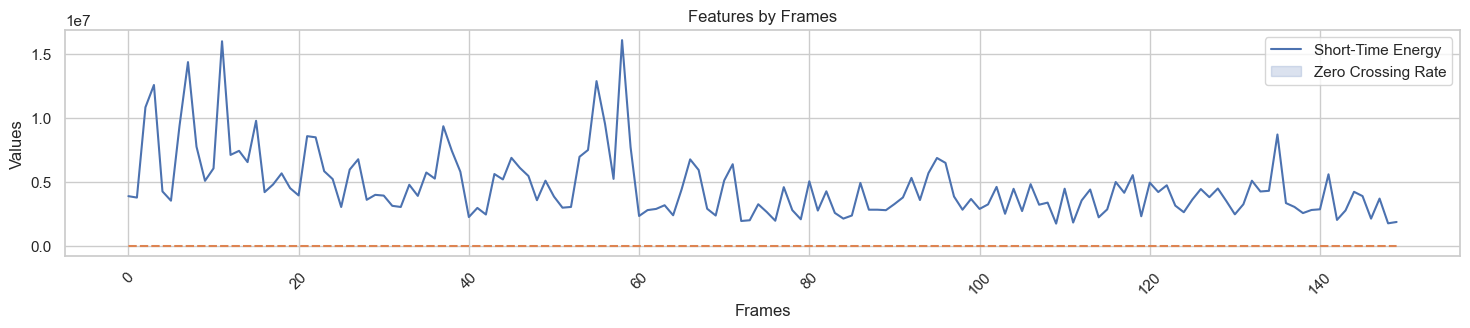

In [171]:


# Set the style of seaborn
sns.set(style='whitegrid')

# Create a figure for visualizations
plt.figure(figsize=(18, 10))

# Line plot for Short-Time Energy and Zero Crossing Rate
plt.subplot(3, 1, 1)
sns.lineplot(data=data[['Short-Time Energy', 'Zero Crossing Rate']])
plt.title('Features by Frames')
plt.xlabel('Frames')
plt.ylabel('Values')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.legend(['Short-Time Energy', 'Zero Crossing Rate'])
plt.show()


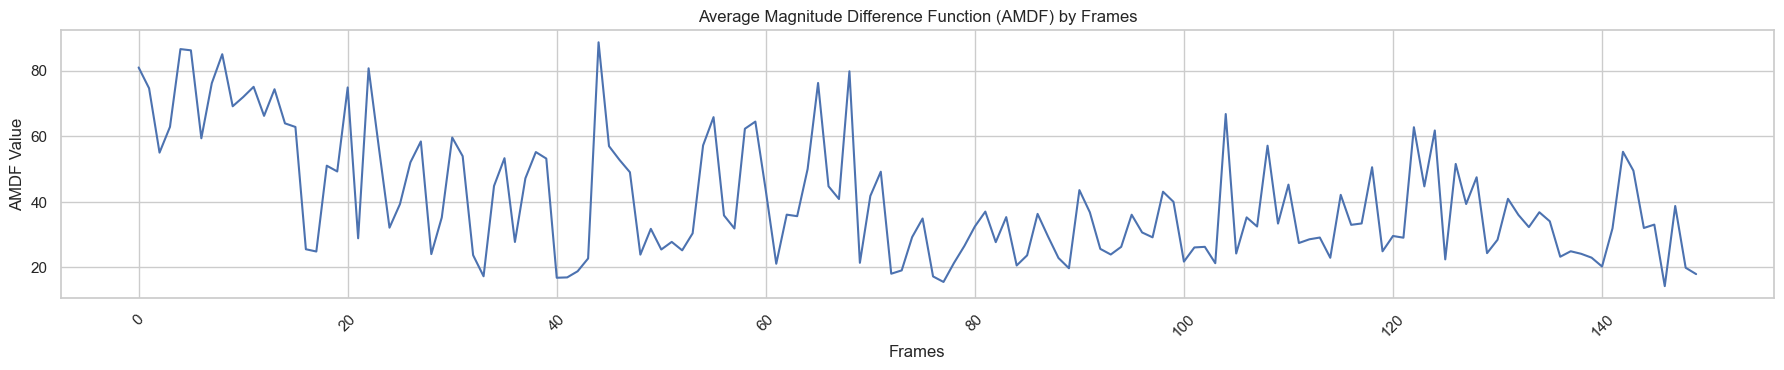

In [173]:
sns.set(style='whitegrid')

# Create a figure for visualizations
plt.figure(figsize=(18, 10))

# Line plot for AMDF
plt.subplot(3, 1, 2)
sns.lineplot(data=data['AMDF'])
plt.title('Average Magnitude Difference Function (AMDF) by Frames')
plt.xlabel('Frames')
plt.ylabel('AMDF Value')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed

# Adjust layout
plt.tight_layout()
plt.show()

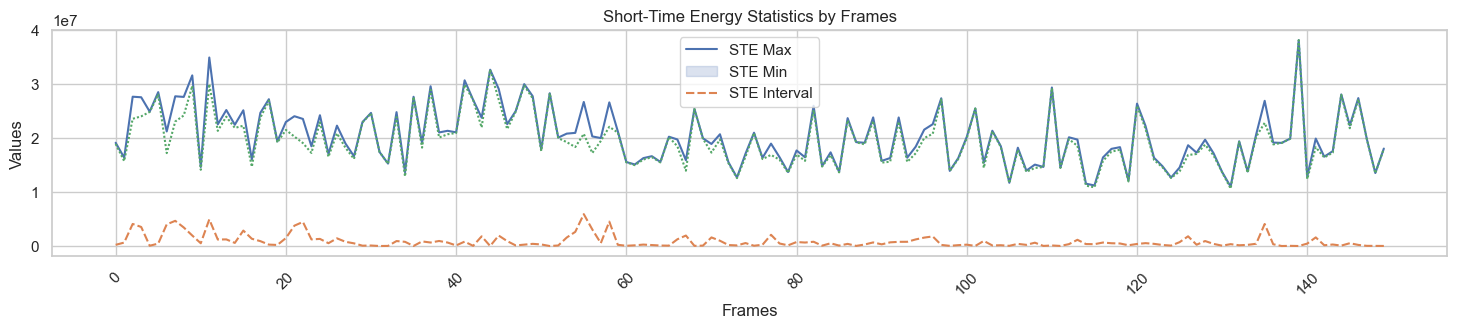

In [174]:
sns.set(style='whitegrid')

# Create a figure for visualizations
plt.figure(figsize=(18, 10))

# Line plot for STE Max, STE Min, and STE Interval
plt.subplot(3, 1, 3)
sns.lineplot(data=data[['STE Max', 'STE Min', 'STE Interval']])
plt.title('Short-Time Energy Statistics by Frames')
plt.xlabel('Frames')
plt.ylabel('Values')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.legend(['STE Max', 'STE Min', 'STE Interval'])
plt.show()

In [175]:
# Separate features and target variable
X = combined_features.drop('Emotion', axis=1)
y = combined_features['Emotion']

In [176]:
 #Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [178]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42)

# Display the shapes of the training and testing sets
print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (3412, 9)
Testing set shape: (1138, 9)


In [179]:
X_train_reshaped = X_train.values.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.values.reshape(X_test.shape[0], -1)

# Display reshaped data shapes
print("\nReshaped Training set shape:", X_train_reshaped.shape)
print("Reshaped Testing set shape:", X_test_reshaped.shape)


Reshaped Training set shape: (3412, 9)
Reshaped Testing set shape: (1138, 9)


In [180]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rf_classifier.fit(X_train_reshaped, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test_reshaped)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Display the accuracy and classification report
print("\nRandom Forest Classifier Accuracy:", accuracy)
print("\nClassification Report:\n", report)



Random Forest Classifier Accuracy: 0.7451669595782073

Classification Report:
               precision    recall  f1-score   support

       angry       0.74      0.73      0.74       153
        calm       0.73      0.78      0.75       139
     disgust       0.66      0.79      0.72       121
     fearful       0.77      0.73      0.75       149
       happy       0.71      0.73      0.72       134
     neutral       0.82      0.75      0.78       143
         sad       0.81      0.70      0.75       151
   surprised       0.73      0.76      0.75       148

    accuracy                           0.75      1138
   macro avg       0.75      0.75      0.75      1138
weighted avg       0.75      0.75      0.75      1138



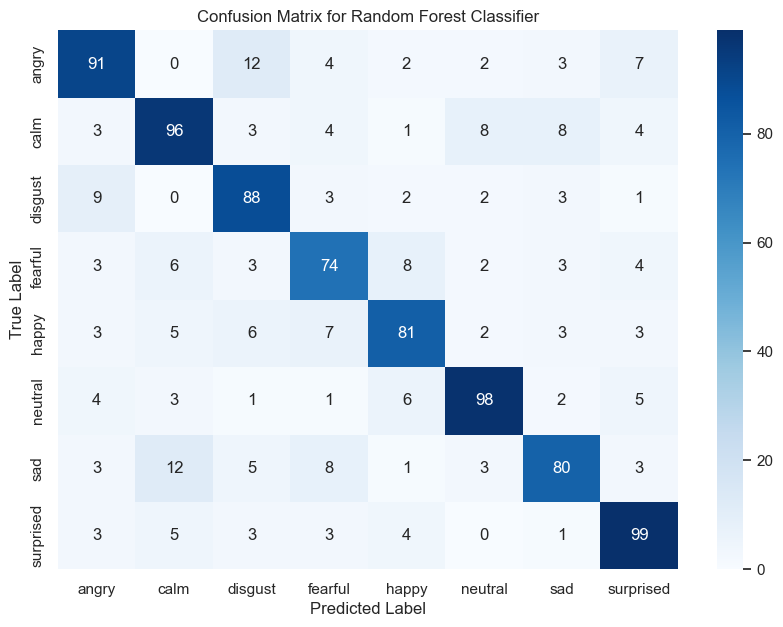

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [148]:
y_train_pred = rf_classifier.predict(X_train_reshaped)
y_test_pred = rf_classifier.predict(X_test_reshaped)

# Calculate accuracy for training and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Display the accuracies
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Check for overfitting
if train_accuracy - test_accuracy > 0.1:  
    print("The model is likely overfitting.")
else:
    print("The model is not overfitting.")

Training Accuracy: 1.0000
Test Accuracy: 0.7668
The model is likely overfitting.


Feature Importances from Random Forest:
                   Feature  Importance
1  Zero Crossing Rate Mean    0.153067
4                  STE Min    0.149396
2                AMDF Mean    0.145549
5                  ZCR Max    0.145179
0   Short-Time Energy Mean    0.144439
3                  STE Max    0.141214
6                  ZCR Min    0.121156


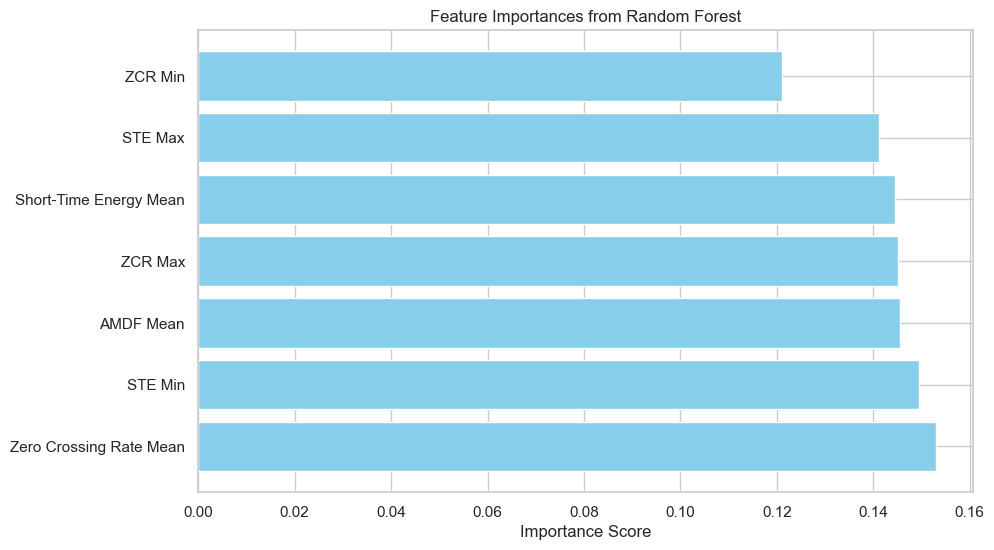

In [149]:
# Get feature importances
importances = rf_classifier.feature_importances_

# Combine feature names and importance scores
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display the feature importance
print("Feature Importances from Random Forest:")
print(feature_importance)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances from Random Forest")
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.show()

In [150]:
y_score = rf_classifier.predict_proba(X_test_reshaped)  # Replace X_test with your actual test set

print("y_test shape:", y_test.shape)
print("y_score shape:", y_score.shape)


y_test shape: (922,)
y_score shape: (922, 8)


In [151]:
from sklearn.preprocessing import LabelBinarizer
# Get predicted probabilities for the test set
y_prob = rf_classifier.predict_proba(X_test)

# Binarize the output
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Calculate ROC curve and AUC for each class
n_classes = y_test_bin.shape[1]


c:\Users\admin\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [152]:
n_classes

8

C:\Users\admin\AppData\Local\Temp\ipykernel_25716\2933378460.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)  # Using a colormap for more colors


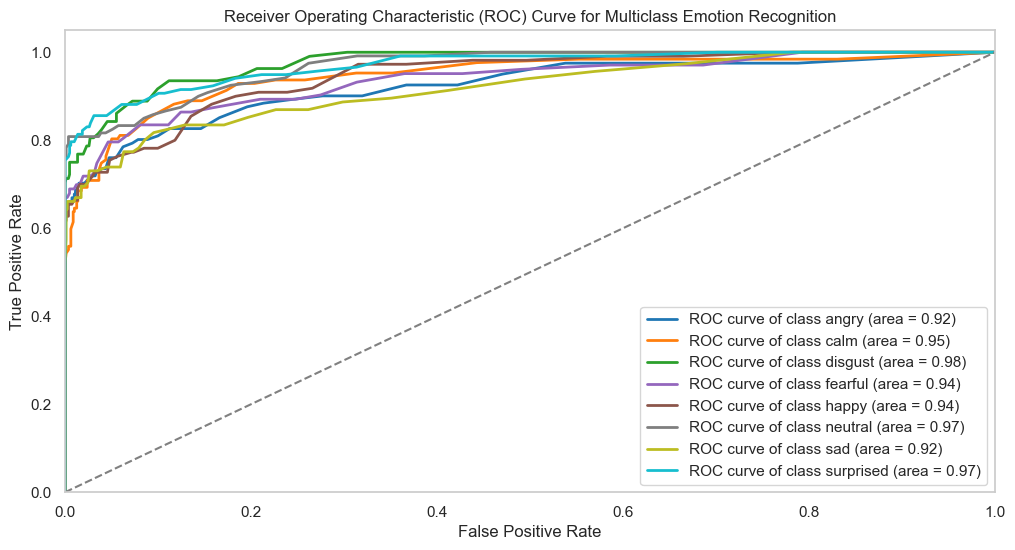

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

# Assuming you have your y_test and y_prob defined
# y_test should be the true labels (1D array), and y_prob should be the predicted probabilities (2D array)

# Step 1: One-hot encode y_test if not already done
encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output instead of sparse
y_test_bin = encoder.fit_transform(y_test.reshape(-1, 1))

# Step 2: Initialize variables for ROC
n_classes = len(encoder.categories_[0])  # Number of classes
fpr = {}
tpr = {}
roc_auc = {}

# Step 3: Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4: Plotting the ROC curve for each class
plt.figure(figsize=(12, 6))
colors = plt.cm.get_cmap('tab10', n_classes)  # Using a colormap for more colors

# Define class names
class_names = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, 
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass Emotion Recognition')
plt.legend(loc='lower right')
plt.grid()
plt.show()
